<h1 align="center">
    TRAINING A VARIATIONAL QUANTUM CLASSIFIER ON THE <i> Breast cancer Wisconsin </i>  DATASET 
</h1>

Here we train a quantum machine learning model on a a real-life classical dataset to tackle a classification task. The dataset considered is the _Breast cancer Wisconsin (diagnostic)_ dataset, available in scikit-learn. For comparison, we’ll first train a classical counterpart to the quantum model.

This notebook takes inspiration from the <a href="https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html"> Training a Quantum Model on a Real Dataset </a> Qiskit Machine Learning tutorial.

**Global workflow:**

1. Load the dataset and explore what it looks like, apply features rescaling and PCA to reduce the number of features, and split the resulting dataset in a training and a test part.

2. Train a classical model using SVC from scikit-learn to see how well the classification problem can be solved using classical methods.

3. Introduce the Variational Quantum Classifier (VQC). Explore different backends: real hardware, hardware simulator, and StatevectorSimulator (exact, non-noisy simulator).

4. Compare the results obtained from the explored models

In [1]:
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Exact_Sampler
from qiskit.transpiler import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from qiskit.circuit.library import zz_feature_map, real_amplitudes, efficient_su2

# Data loading, analysis, PCA, and manipulation

The _Breast Cancer_ dataset consists of 569 datapoints, 30 numeric features, and 2 classes (binary classification).
It is loaded as a dictionary-like object with the followying keys:
- data
- target
- feature_names
- target_names
- DESCR
- filename
- ...

We employ _zz Feature Map_ for data encoding, which requires a number of qubits equal to the number of features; since this approach would require too many qubits for both local simulation and real hardware exploitation, we reduce the number of features performing a Principal Components Analysis (PCA). Features are originally not normalized and their value ranges are different; since the PCA is sensible to such differences, we first scale the raw features with Standard Scaler, whcih maps each of them to a distribution with mean = 0 and variance = 1.

After obtaining the PCA features, we map them in a range suitable for the feature map employed; for the zz Feature Map, we use _MinMaxScaler_ to obtain features in the [0,1] interval. We perform these steps entirely using **_scikit-learn_** tools.

We proceed by plotting the PCA features pair-wise to see if there’s an observable correlation between them. We do this with **_seaborn_**. Seaborn works well with **_pandas_** dataframes, so we first need to build the dataframe starting from the sklearn dataset. Pandas dataframes are created with the constructor

``` pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)```,

where
- data: it's the real content. It can be a numpy array, a dictionary, a list of lists, etc.
- columns: these are the columns names.
- index: the rows names. Default ones are numbers starting from 0

We stress that, in this notebook, Pandas is used only as a bridge for Seaborn, that is, only for a graphical reason. **If data visualization is of no interest, Pandas and Seaborn can be avoided as a whole.**

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

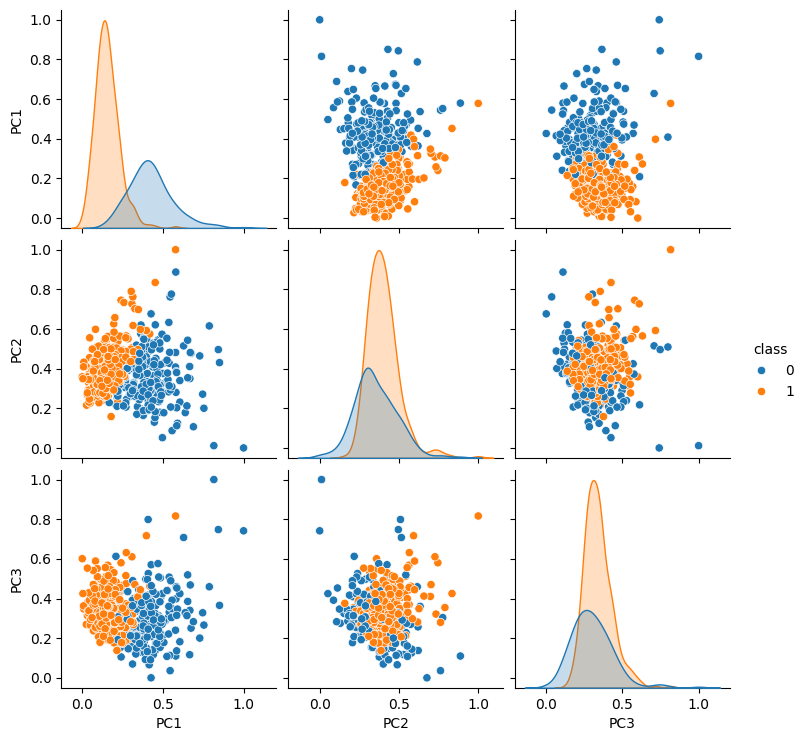

In [2]:
##################################################################################################
# Load dataset, print information, extract features and labels, and manipulate them
cancer_dataset = load_breast_cancer()   # load dataset: return a dictionary-like object
print(cancer_dataset.DESCR)   # print information
print("---------------------------------------------------------------------------------------\n")

labels = cancer_dataset.target   # extract labels as a numpy (num features x 1) array
raw_features = cancer_dataset.data   # extract features as a numpy (num datapoints x num features) array

scaled_features = StandardScaler().fit_transform(raw_features)   # mean = 0, variance = 1
n_components = 3
pca = PCA(n_components)   # create PCA
pca_features = pca.fit_transform(scaled_features)   # apply PCA ---> reduce number of features to 3
normalized_features = MinMaxScaler().fit_transform(pca_features)   # re-scale features to the [0,1] range for data encoding

pca_variances = pca.explained_variance_ratio_   # variance captured by each PCs:
print(f"Variance captured by PC1, PC2, PC3: {pca_variances}\n")

##################################################################################################
# Plot PCA features pair-wise to look for correlations visually
df = pd.DataFrame(data = normalized_features, columns = ["PC1", "PC2", "PC3"])   # create a Pandas DataFrame. Columns are named after the PCA features
df["class"] = labels   # add the "class" column with target values
sns.pairplot(df, hue = "class", palette = "tab10")   # a matrix of graphs, comparing each df column with all the others and coloring datapoints according to their class

##################################################################################################
# Split the dataset into a training part and a a test part
algorithm_globals.random_seed = 123   # fix the seed to ensure the results are reproducible.
train_features, test_features, train_labels, test_labels = train_test_split(
    normalized_features,
    labels,
    train_size = 0.8,
    random_state = algorithm_globals.random_seed
)

#  Training a Classical Machine Learning Model

We now train a classical Support Vector Classifier from scikit-learn, using the default parameters. Finally, we check the classical model performance

In [3]:
# Train a classical Support Vector Classifier from scikit-learn
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

train_score_classic = svc.score(train_features, train_labels)
test_score_classic = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_classic:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_classic:.2f}")

Classical SVC on the training dataset: 0.95
Classical SVC on the test dataset:     0.97


# Training a Quantum Machine Learning Model

We’ll train a variational quantum classifier (VQC), the simplest classifier available in Qiskit Machine Learning.

**Feature map**: ZZ feature map, whose constructor is

```zz_feature_map(feature_dimension, reps=2, entanglement='full', alpha=2.0, data_map_func=None, parameter_prefix='x', insert_barriers=False, name='ZZFeatureMap')```.

We pass the number of PCA features as feature_dimension ---> 3 qubits

**Ansatz**: efficient_su2, whose constructor is

```efficient_su2(num_qubits, su2_gates=None, entanglement='reverse_linear', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, parameter_prefix='θ', insert_barriers=False, name='EfficientSU2')```

**Optimizer**: COBYLA (gradient free optimizer)

**Backend and primitive**: we prepare both a real quantum hardware backend with error suppression and mitigation techniques, and a local simulator backend (in this case, error suppression and mitigation techniques are useless). We prepare a Sampler primitive for each of them, together with a StatevectorSampler for exact simulations.

We recall that the class VQC is build with the constructor:

```VQC(num_qubits=None, feature_map=None, ansatz=None, loss='cross_entropy', optimizer=None, warm_start=False, initial_point=None, callback=None, *, sampler=None, interpret=None, output_shape=None, pass_manager=None)```

Feature map - number of encoded parameters (features loaded): 3. Circuit:


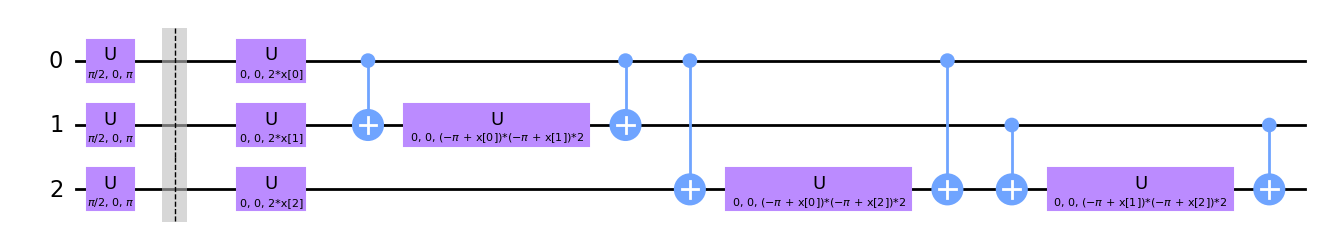

Ansatz - number of encoded parameters (trainable weights): 18. Circuit:


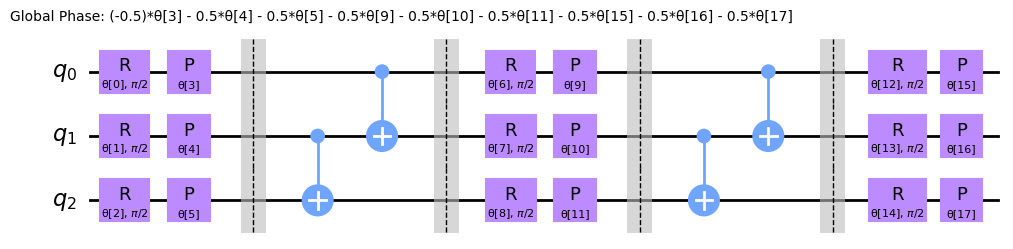

Chosen backend for circuit transpilation: <IBMBackend('ibm_fez')>


In [4]:
##################################################################################################
# Create the quantum circuit
feature_map = zz_feature_map(feature_dimension = n_components, reps = 1, insert_barriers = True)   # feature map circuit
print(f"Feature map - number of encoded parameters (features loaded): {feature_map.num_parameters}. Circuit:")
display(feature_map.decompose().draw(output = "mpl", style = "clifford", fold = 50))

ansatz = efficient_su2(num_qubits = n_components, reps = 2, insert_barriers = True)   # ansatz circuit
print(f"Ansatz - number of encoded parameters (trainable weights): {ansatz.num_parameters}. Circuit:")
display(ansatz.decompose().draw(output = "mpl", style = "clifford", fold = 50))

##################################################################################################
# Chose backends and transpile circuit with a pass manager
service = QiskitRuntimeService()
transpilation_backend = service.least_busy(simulator = False, operational = True)
pm = generate_preset_pass_manager(backend = transpilation_backend, optimization_level = 3)
print(f"Chosen backend for circuit transpilation: {transpilation_backend}")

real_backend = transpilation_backend
simulator_backend = AerSimulator(noise_model = NoiseModel.from_backend(transpilation_backend))

##################################################################################################
# Define the chosen primitive and apply the desired error suppression/mitigation techniques. VQC requires a Sampler primitive
# Sampler using real quantum hardware as backend
real_sampler = Sampler(mode = real_backend) 
real_sampler.options.dynamical_decoupling.enable = True
real_sampler.options.dynamical_decoupling.sequence_type = "XY4"
real_sampler.options.twirling.enable_gates = True
real_sampler.options.twirling.num_randomizations = "auto"
real_sampler.options.max_execution_time = 180   # set 3 minutes of maximum execution time

# Sampler using a simulator of real quantum hardware as backend - usefull to test runtime
simulator_sampler = Sampler(mode = simulator_backend) 

# Sampler using a StatevectorSimulator as backend, which computes the exact state vector
statevector_sampler = Exact_Sampler()

##################################################################################################
# Define callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, loss_func_value):
    clear_output(wait = True)   # clear the output generated up to now. Wait for generation of new output before cleaning old one
    loss_func_array.append(loss_func_value)
    plt.title(f"Objective function value VS iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(loss_func_array)), loss_func_array)
    plt.show()

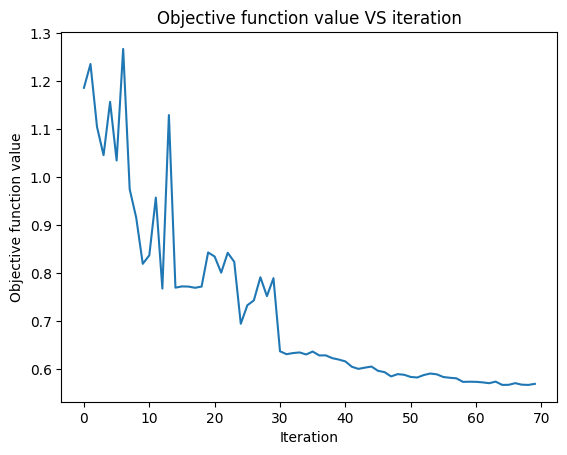

In [7]:
##################################################################################################
# Choose the desired execution mode (real hardware, noisy simulator, statevector), which determines the employed sampler primitive and backend
execution_mode = "statevector simulator"   # choose either "statevector simulator", "noisy simulator", or "quantum hardware"

if execution_mode == "statevector simulator":
    sampler_to_use = statevector_sampler
    pm_to_use = None
elif execution_mode == "noisy simulator":
    sampler_to_use = simulator_sampler
    pm_to_use = pm
elif execution_mode == "quantum hardware":
    sampler_to_use = real_sampler
    pm_to_use = pm

##################################################################################################
# Construct the variational quantum classifier
maxiter = 70
loss_func_array = []   # create an empty array for callback to store evaluations of the objective function
vqc = VQC(
    # elements part of the neural network
    feature_map = feature_map,
    ansatz = ansatz,
    sampler = sampler_to_use,
    # elements part of the classifier
    loss = "cross_entropy",
    optimizer = COBYLA(maxiter = maxiter),
    callback = callback_graph,
    pass_manager = pm_to_use
)

##################################################################################################
# Train the model : fit the classifier with the data
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

##################################################################################################
# Evaluate the classifier performance
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

##################################################################################################
# Create a dictionary gathering the results of different runs, to compare performance of different parameters and execution modes
current_run = {
    f"{execution_mode} - Feature map": f"{feature_map.name} with depth {feature_map.depth()}",
    f"{execution_mode} - Ansatz": f"{ansatz.name} with depth {ansatz.depth()}",
    f"{execution_mode} - Training time (seconds)": round(elapsed, 0),
    f"{execution_mode} - Employed maxiter": maxiter,
    f"{execution_mode} - Total number of function evaluations": vqc.fit_result.nfev,
    f"{execution_mode} - Final value of the loss function": round(vqc.fit_result.fun,5),
    f"{execution_mode} - Training score": f"{train_score:.2f}",
    f"{execution_mode} - Test score": f"{test_score:.2f}",
    "-----": "-----",
    f"classical model - Training score": f"{train_score_classic:.2f}",
    f"classical model - Test score": f"{test_score_classic:.2f}",
    "-----": "-----",
}   # a dictionary containing the results

if 'results' not in globals():
    results = {}
results.update(current_run)

In [8]:
# Print the dictionary containing the results
for key, value in results.items():
    print(f"{key}: {value}")

noisy simulator - Feature map: ZZFeatureMap with depth 11
noisy simulator - Ansatz: EfficientSU2 with depth 10
noisy simulator - Training time (seconds): 240.0
noisy simulator - Employed maxiter: 70
noisy simulator - Total number of function evaluations: 70
noisy simulator - Final value of the loss function: 0.52213
noisy simulator - Training score: 0.87
noisy simulator - Test score: 0.83
-----: -----
classical model - Training score: 0.95
classical model - Test score: 0.97
statevector simulator - Feature map: ZZFeatureMap with depth 11
statevector simulator - Ansatz: EfficientSU2 with depth 10
statevector simulator - Training time (seconds): 186.0
statevector simulator - Employed maxiter: 70
statevector simulator - Total number of function evaluations: 70
statevector simulator - Final value of the loss function: 0.56679
statevector simulator - Training score: 0.86
statevector simulator - Test score: 0.82
